In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
## 데이터 불러오기
records = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/records.csv')
customer_stats = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/customer_stats.csv')

## 1. EDA

### 1-1. 카테고리별 주문량

In [4]:
## 카테고리별 주문량 구하기
selling_count = pd.DataFrame(records['category'].value_counts())
selling_count = selling_count.reset_index()
# 컬럼 이름 변경하기
selling_count.rename(columns = {'index': 'category', 'category': 'selling_count'}, inplace=True)
# 비율 컬럼 추가하기
selling_count['ratio'] = selling_count['selling_count'] / selling_count['selling_count'].sum()
selling_count

,category,selling_count,ratio
0,Office Supplies,2002,0.604469
1,Furniture,686,0.207126
2,Technology,624,0.188406


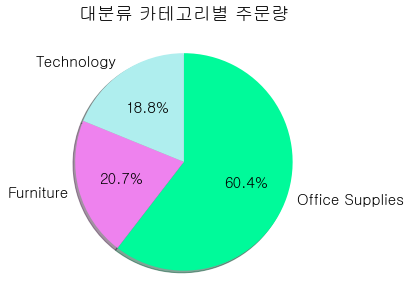

In [5]:
## pie chart 그리기
labels = selling_count['category']
points = selling_count['ratio']

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax = fig.add_subplot()

pie = ax.pie(points, labels=labels, autopct='%.1f%%', counterclock=False, startangle=90, 
             shadow=True, colors=['mediumspringgreen', 'violet', 'paleturquoise'], textprops={'fontsize': 15})
plt.title('대분류 카테고리별 주문량', size=18)

plt.show()

### 1-2. 대분류, 중분류 카테고리별 주문량 Top 5

In [6]:
records.head(2)

,order_date,order_id,ship_mode,customer_id,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,2020-01-01,CA-2017-107503,Standard Class,GA-14725,Consumer,United States,Lorain,Ohio,44052,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",48.896,4,0.2,8.5568
1,2020-01-01,CA-2017-144463,Standard Class,SC-20725,Consumer,United States,Los Angeles,California,90036,West,FUR-FU-10001215,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Brentwood Wall ...",474.430,11,0.0,199.2606


In [7]:
## 대분류, 중분류 별로 그룹화
category_count = pd.DataFrame(records.groupby(['category', 'sub_category'])['quantity'].sum())
# 내림차순으로 정렬
category_count = category_count.sort_values(by='quantity', ascending=False)
# 인덱스 리셋
category_count = category_count.reset_index()
# 상위 5개만 가져오기
category_count = category_count.iloc[0:5]
category_count

,category,sub_category,quantity
0,Office Supplies,Binders,2067
1,Office Supplies,Paper,1702
2,Office Supplies,Art,1101
3,Furniture,Furnishings,1097
4,Technology,Phones,1090


### 1-3. 고객군별 판매량, 매출액

In [8]:
records = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/records.csv')

In [9]:
## order_id에 중복이 존재하므로 order_id별로 그룹화
records = pd.DataFrame(records.groupby(['order_id', 'segment'])['sales'].sum())
records = records.reset_index()
# 고객군별 주문량
segment = pd.DataFrame(records['segment'].value_counts())
segment = segment.reset_index()
segment
# 컬럼 이름 변경하기
segment.rename(columns = {'index': 'segment', 'segment': 'selling_count'}, inplace=True)
# 비율 컬럼 추가하기
segment['ratio'] = segment['selling_count'] / segment['selling_count'].sum()
segment
# 고객군별 매출액
segment_sales = pd.DataFrame(records.groupby('segment')['sales'].sum())
segment_sales = segment_sales.reset_index()
segment_sales['sales_ratio'] = segment_sales['sales'] / segment_sales['sales'].sum()
segment_sales

,segment,sales,sales_ratio
0,Consumer,331904.6999,0.452670
1,Corporate,241847.8244,0.329846
2,Home Office,159462.7309,0.217484


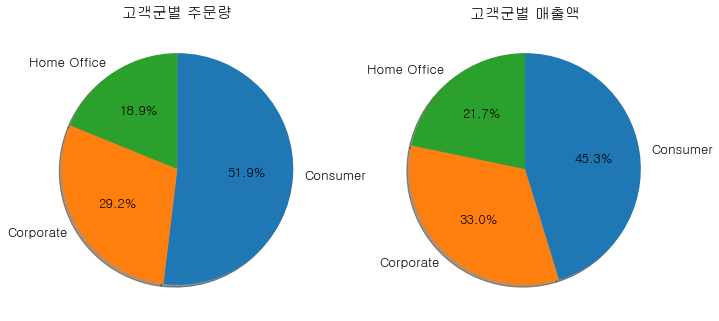

In [10]:
## pie chart 그리기
# pie chart 1
labels = segment['segment']
points = segment['ratio']

fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')

plt.subplot(121)
plt.title('고객군별 주문량', size=15)
plt.pie(points, labels=labels, autopct='%.1f%%', counterclock=False, startangle=90, 
        shadow=True, textprops={'fontsize': 13})

# pie chart 2
labels = segment_sales['segment']
points = segment_sales['sales']

plt.subplot(122)
plt.title('고객군별 매출액', size=15)
plt.pie(points, labels=labels, autopct='%.1f%%', counterclock=False, startangle=90, 
        shadow=True, textprops={'fontsize': 13})

# 그래프 사이 간격 조정
plt.subplots_adjust(left=0.125, right=1.6, wspace=0.2, hspace=0.2)

# 사진으로 저장하기
# plt.savefig('카테고리별주문량.png')

## 2. RFM 점수부여 기준 설정

### 2-1. 주문횟수별 고객비율

In [11]:
cnt_orders = pd.DataFrame(customer_stats['cnt_orders'])
cnt_orders.describe()

,cnt_orders
count,693.000000
mean,2.434343
std,1.307085
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,8.000000


In [12]:
## 각 주문횟수 별로 몇 명의 고객이 속하는지 확인
# DataFrame으로 만들기
cnt_orders = pd.DataFrame(customer_stats['cnt_orders'].value_counts())
cnt_orders = cnt_orders.reset_index()
# 컬럼 이름 변경하기
cnt_orders.rename(columns = {'index': '구매횟수', 'cnt_orders': '고객수'}, inplace=True)
# 백분율 컬럼 추가하기
cnt_orders['백분율'] = (cnt_orders['고객수'] / len(customer_stats))
cnt_orders['백분율'] = round(cnt_orders['백분율'], 3)      # 소수점 셋째자리까지 반올림
# 컬럼의 값 변경하기
cnt_orders['구매횟수'] = ['1번', '2번', '3번', '4번', '5번', '6번', '7번', '8번']
cnt_orders

,구매횟수,고객수,백분율
0,1번,200,0.289
1,2번,200,0.289
2,3번,156,0.225
3,4번,85,0.123
4,5번,39,0.056
5,6번,9,0.013
6,7번,2,0.003
7,8번,2,0.003


#### 2-1-1. pie chart

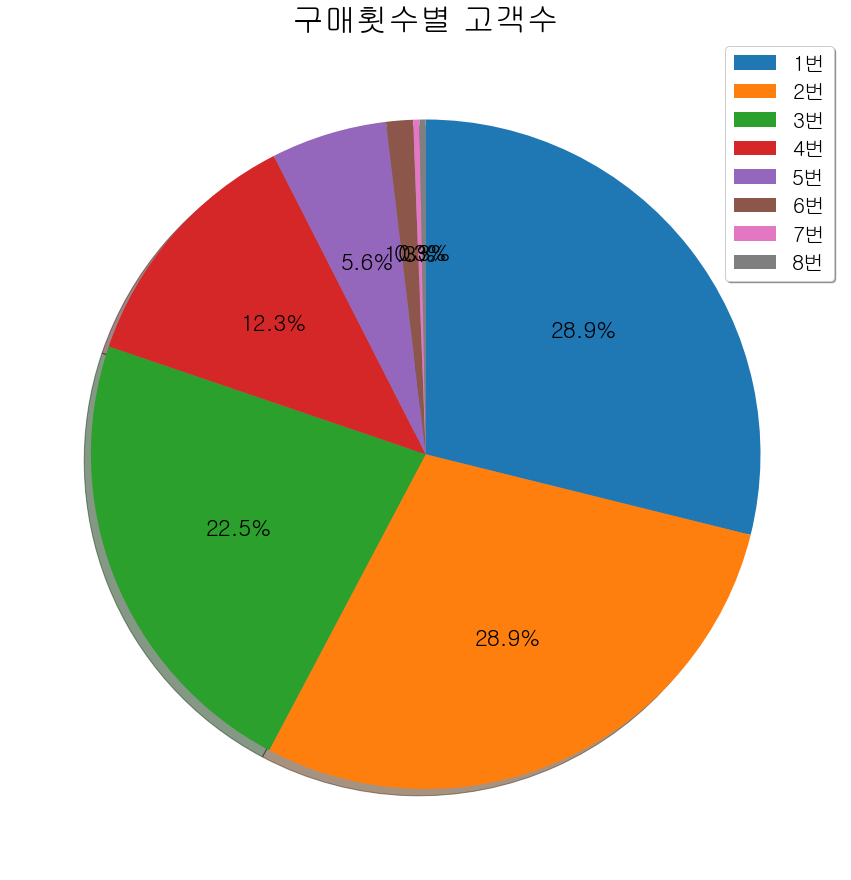

In [13]:
## pie chart 그리기
labels = cnt_orders['구매횟수']
points = cnt_orders['백분율']
fig = plt.figure(figsize=(15,18))
fig.set_facecolor('white')          # 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot()

pie = ax.pie(points, autopct='%.1f%%', counterclock=False, startangle=90, 
             shadow=True, textprops={'fontsize': 22.5})
plt.title('구매횟수별 고객수', fontsize=32)

plt.legend(pie[0], labels, frameon=True, shadow=True, fontsize=21)
plt.show()

#### 2-1-2. bar chart

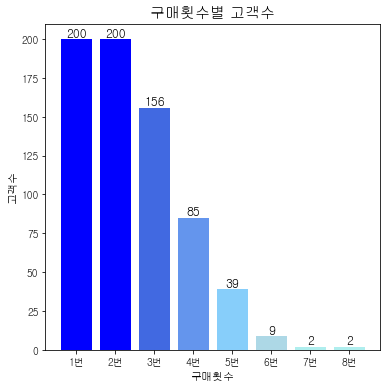

In [14]:
## bar chart
labels = cnt_orders['구매횟수']
points = cnt_orders['고객수']

fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')
ax = fig.add_subplot()

bar = ax.bar(labels, points, color=['blue', 'blue', 'royalblue', 'cornflowerblue', 'lightskyblue', 'lightblue', 'paleturquoise', 'paleturquoise'])

# 그래프에 값 표시하기
for i, v in enumerate(labels):
    plt.text(v, points[i], points[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, 
             color='black',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.xlabel('구매횟수', fontsize=11)
plt.ylabel('고객수', fontsize=11)
plt.title('구매횟수별 고객수', fontsize=15)
plt.show()

#### 2-1-3. box plot

In [15]:
cnt_orders = pd.DataFrame(customer_stats['cnt_orders'])
cnt_orders

,cnt_orders
0,1
1,2
2,1
3,1
4,4
...,...
688,4
689,1
690,5
691,4


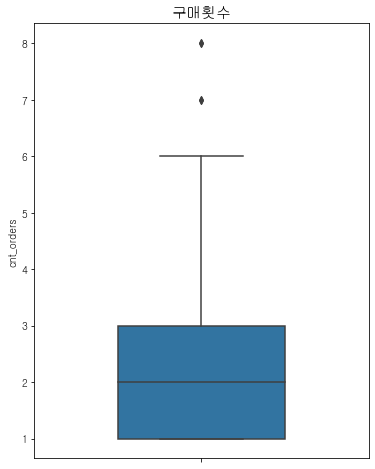

In [16]:
## box plot
fig = plt.figure(figsize=(6,8))
fig.set_facecolor('white')

sns.boxplot(y='cnt_orders', data=cnt_orders, width=0.5)
plt.title('구매횟수', size=15)
plt.show()

### 2-2. 매출액 범위별 고객 수

In [17]:
records = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/records.csv')

In [18]:
## customer_id에 중복이 존재하므로 customer_id별로 그룹화
records = pd.DataFrame(records.groupby(['customer_id'])['sales'].sum())
records = records.reset_index()
records

,customer_id,sales
0,AA-10315,374.480
1,AA-10375,206.732
2,AA-10480,15.552
3,AA-10645,12.960
4,AB-10060,2936.264
...,...,...
688,XP-21865,449.312
689,YC-21895,750.680
690,YS-21880,5340.264
691,ZC-21910,227.066


#### 2-2-1. sales 컬럼을 범위에 따라 범주화

In [19]:
## sales를 범위에 따라 범주화
r = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 3000, 5000, 10000, 20000]
g = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
records['salesband'] = pd.cut(records['sales'], bins=r, labels=g)

# 해당 범주에 속하는 고객 수 count
new = pd.DataFrame(records.groupby('salesband')['customer_id'].count())
new = new.reset_index()

# 범위를 나타내는 컬럼 추가
new = pd.DataFrame(records.groupby('salesband')['customer_id'].count())
new = new.reset_index()
# 컬럼 추가
new.rename(columns = {'customer_id': 'customer_count'}, inplace=True)
new['백분율'] = (new['customer_count'] / len(records))
new['백분율'] = round(new['백분율'], 3)
new['sales'] = ['0~100', '100~200', '200~300', '300~400', '400~500', 
                '500~600', '600~700', '700~800', '800~900', '900~1000', 
                '1000~3000', '3000~5000', '5000~10000', '10000 초과']
new

,salesband,customer_count,백분율,sales
0,1,114,0.165,0~100
1,2,56,0.081,100~200
2,3,58,0.084,200~300
3,4,43,0.062,300~400
4,5,34,0.049,400~500
5,6,40,0.058,500~600
6,7,29,0.042,600~700
7,8,29,0.042,700~800
8,9,37,0.053,800~900
9,10,16,0.023,900~1000


#### 2-2-2. bar chart

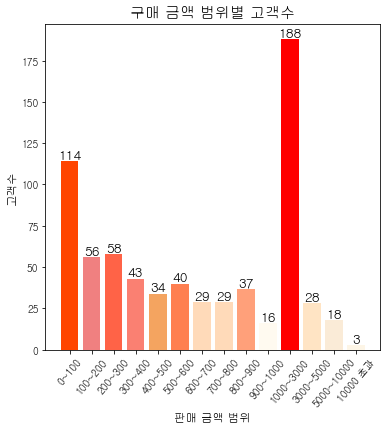

In [20]:
## barplot
labels = new['sales']
points = new['customer_count']
# percent = new['백분율']

fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')
ax = fig.add_subplot()

barplot = ax.bar(labels, points, color=['orangered', 'lightcoral', 'tomato', 'salmon', 'sandybrown', 'coral', 
                               'peachpuff', 'peachpuff', 'lightsalmon', 'floralwhite', 'red', 'bisque', 'antiquewhite', 'oldlace'])


# 그래프에 값 표시하기
for i, v in enumerate(labels):
    plt.text(v, points[i], points[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 13.5, 
             color='black',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.xlabel('판매 금액 범위', fontsize=11.5)
plt.ylabel('고객수', fontsize=11.5)
plt.title('구매 금액 범위별 고객수', fontsize=15)
plt.xticks(rotation = 50)

plt.show()

#### 2-2-3. pie chart

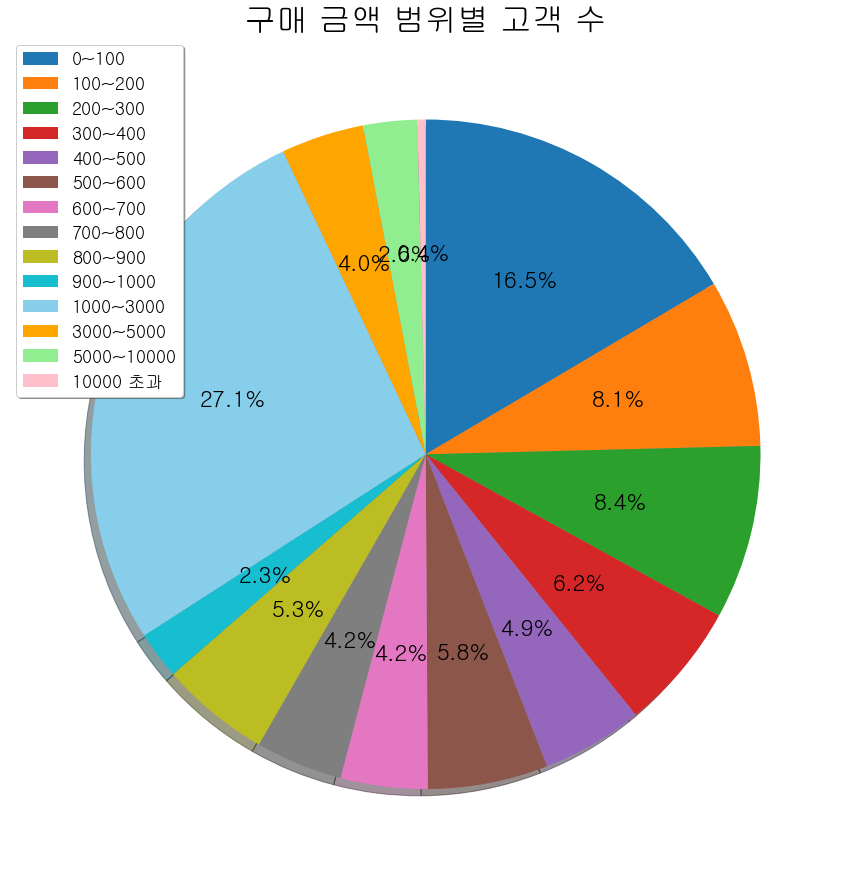

In [21]:
## pie chart
labels = new['sales']
points = new['백분율']
fig = plt.figure(figsize=(15,18))
fig.set_facecolor('white')
ax = fig.add_subplot()

pie = ax.pie(points, autopct='%.1f%%', counterclock=False, startangle=90, 
             shadow=True, textprops={'fontsize': 22.5}, 
             colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                     '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'skyblue', 'orange', 
                     'lightgreen', 'pink'])
plt.title('구매 금액 범위별 고객 수', fontsize=32)
plt.legend(pie[0], labels, frameon=True, shadow=True, fontsize=17.5)      # 범례 추가
plt.show()

#### 2-2-4. box plot

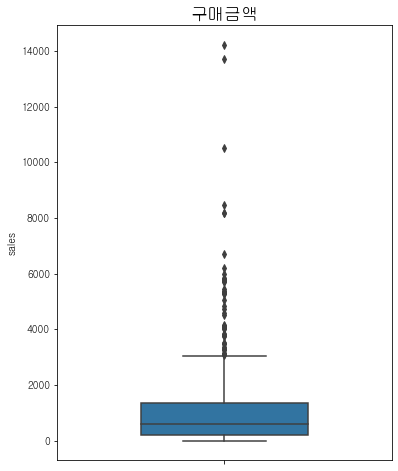

In [22]:
## box plot
fig = plt.figure(figsize=(6,8))
fig.set_facecolor('white')

sns.boxplot(y='sales', data=records, width=0.5)
plt.title('구매금액', size=17)
plt.show()

In [23]:
records['sales'].median()

604.91

### 2-3. 고객별 평균 구매 주기

In [25]:
order_cycle = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/고객별_평균_구매주기.csv')

In [26]:
## 재구매 이력이 없는 고객은 order_cycle_avg 컬럼을 0으로 채우기
order_cycle['order_cycle_avg'] = order_cycle['order_cycle_avg'].fillna(0)
order_cycle.head(3)

,customer_id,order_cycle_avg
0,AA-10315,0.0
1,AA-10375,95.0
2,AA-10480,0.0


In [27]:
order_cycle[order_cycle['order_cycle_avg'] == 0]

,customer_id,order_cycle_avg
0,AA-10315,0.0
2,AA-10480,0.0
3,AA-10645,0.0
9,AB-10600,0.0
10,AC-10420,0.0
...,...,...
682,VM-21835,0.0
684,VP-21760,0.0
685,VS-21820,0.0
689,YC-21895,0.0


In [28]:
## 구매주기를 범위에 따라 범주화
r = [0.0, 0.99, 25, 50, 75, 100, 200, 400]
g = [1, 2, 3, 4, 5, 6, 7]
order_cycle['cycle_band'] =pd.cut(order_cycle['order_cycle_avg'], bins=r, labels=g)
# cycle_band 컬럼이 null인 행은 1로 채우기
order_cycle['cycle_band'] = order_cycle['cycle_band'].fillna(1)
# 해당 범주에 속하는 고객 수 count
new2 = pd.DataFrame(order_cycle.groupby('cycle_band')['customer_id'].count())
new2 = new2.reset_index()

# 컬럼 이름 변경 및 컬럼 추가
new2.rename(columns = {'customer_id': 'customer_count'}, inplace=True)
new2['백분율'] = (new2['customer_count'] / len(order_cycle))
new2['백분율'] = round(new2['백분율'], 3)

new2['cycle'] = ['0일', '1~25일', '25~50일', '50~75일', '75~100일', '100~200일', '200~400일']
new2

,cycle_band,customer_count,백분율,cycle
0,1,200,0.289,0일
1,2,52,0.075,1~25일
2,3,69,0.100,25~50일
3,4,111,0.160,50~75일
4,5,88,0.127,75~100일
5,6,124,0.179,100~200일
6,7,49,0.071,200~400일


#### 2-3-1. pie chart

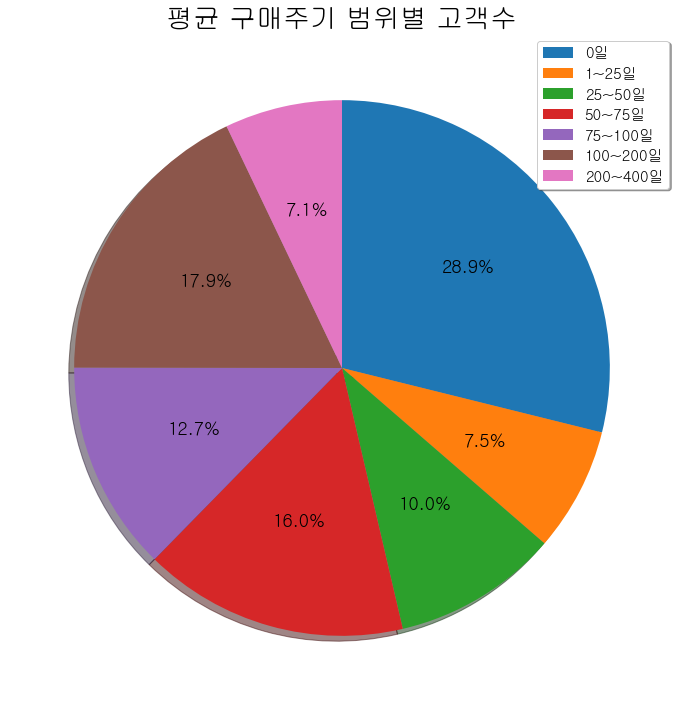

In [29]:
## pie chart
labels = new2['cycle']
points = new2['백분율']
fig = plt.figure(figsize=(12, 15))
fig.set_facecolor('white')          # 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot()

pie = ax.pie(points, autopct='%.1f%%', counterclock=False, startangle=90, shadow=True, textprops={'fontsize': 18})
plt.title('평균 구매주기 범위별 고객수', fontsize=27)
plt.legend(pie[0], labels, frameon=True, shadow=True, fontsize=15)      # 범례 추가   # frameon: 범례 상자 테두리 표시 여부
plt.show()

#### 2-3-2. box plot

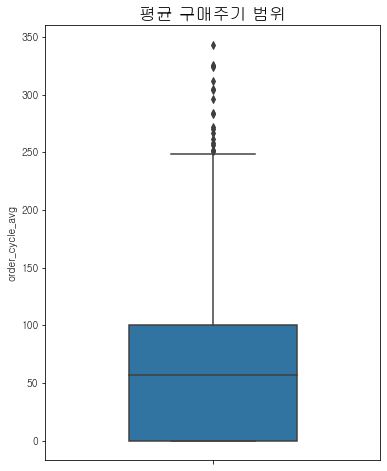

In [30]:
## box plot
fig = plt.figure(figsize=(6,8))
fig.set_facecolor('white')

sns.boxplot(y='order_cycle_avg', data=order_cycle, width=0.5)
plt.title('평균 구매주기 범위', size=17)
plt.show()

### 2-4. 고객들의 마지막 주문 월

In [31]:
records = pd.read_csv('C:/Users/User/Desktop/프로젝트/data/records.csv')

In [32]:
## customer_id에 중복이 존재하므로 customer_id별로 그룹화
records = pd.DataFrame(records.groupby('customer_id')['order_date'].max())
records = records.reset_index()
# 연도, 월만 추출
records['order_date'] = records['order_date'].str[0:7]
# 컬럼 이름 변경
records.rename(columns = {'order_date': 'last_order_month'}, inplace=True)
records

,customer_id,last_order_month
0,AA-10315,2020-06
1,AA-10375,2020-12
2,AA-10480,2020-04
3,AA-10645,2020-11
4,AB-10060,2020-11
...,...,...
688,XP-21865,2020-11
689,YC-21895,2020-12
690,YS-21880,2020-12
691,ZC-21910,2020-11


In [33]:
## order_month별로 그룹화하여 고객 수 count
customer_last_order = pd.DataFrame(records.groupby('last_order_month')['customer_id'].count())
customer_last_order = customer_last_order.reset_index()
# 컬럼 이름 변경
customer_last_order.rename(columns = {'customer_id': 'customer_count'}, inplace=True)
customer_last_order

,last_order_month,customer_count
0,2020-01,13
1,2020-02,4
2,2020-03,18
3,2020-04,11
4,2020-05,21
5,2020-06,32
6,2020-07,34
7,2020-08,29
8,2020-09,95
9,2020-10,79


In [34]:
# 총 고객수: 693명
# print('총 고객 수: ', customer_last_order['customer_count'].sum())
# 비율
percentage = pd.DataFrame(np.round((customer_last_order['customer_count'] / customer_last_order['customer_count'].sum()) * 100, 1))
percentage = percentage.rename(columns = {'customer_count': 'percentage'})
total = pd.concat([customer_last_order, percentage], axis=1)
total

,last_order_month,customer_count,percentage
0,2020-01,13,1.9
1,2020-02,4,0.6
2,2020-03,18,2.6
3,2020-04,11,1.6
4,2020-05,21,3.0
5,2020-06,32,4.6
6,2020-07,34,4.9
7,2020-08,29,4.2
8,2020-09,95,13.7
9,2020-10,79,11.4


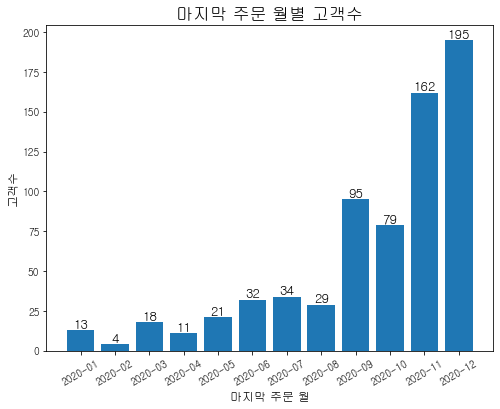

In [35]:
## bar chart
labels = customer_last_order['last_order_month']
points = customer_last_order['customer_count']

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()

bar = ax.bar(labels, points)

# 그래프에 값 표시하기
for i, v in enumerate(labels):
    plt.text(v, points[i], points[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 13, 
             color='black',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.xlabel('마지막 주문 월', fontsize=12)
plt.ylabel('고객수', fontsize=12)
plt.title('마지막 주문 월별 고객수', fontsize=17)
plt.xticks(rotation=30)
plt.show()